In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from task_func import *
import seaborn as sns
import zipfile

import warnings
warnings.filterwarnings("ignore")

## Import Data

In [5]:
archive = zipfile.ZipFile('data/github_profiles_samples.zip','r')
data = [json.loads(line) for line in archive.open('data/github_profiles_samples.jsonl')]

## Task 1 (Programming Language Statistics)

### 1. Parse Programming languages per profile

We want to make a dictionary of each profile and their programming languages. I choose dictionary so that we can retain the information of the user.

In [6]:
user_data_dict = get_language(data)
user_data_dict['5f701050c77de72045952016']

['JavaScript', 'CSS', 'HTML', 'Jupyter Notebook']

### 2. Compute and Visualize statistics

#### User percentage per language

In [7]:
lang_data = countable_lang(user_data_dict) #From dictionary to list
most_used_lang = most_used_language(lang_data, 15) #Return 15 highest most used language and the number of user
most_used_lang

[('HTML', 33755),
 ('JavaScript', 31917),
 ('CSS', 29703),
 ('Python', 22089),
 ('Shell', 19166),
 ('Java', 19091),
 ('C++', 13339),
 ('C', 12515),
 ('PHP', 10713),
 ('Makefile', 10042),
 ('Ruby', 9753),
 ('TypeScript', 8210),
 ('C#', 8088),
 ('Objective-C', 6478),
 ('Jupyter Notebook', 6316)]

In [8]:
#percentage
language_percentage = calculate_language_percentage(most_used_lang, user_data_dict) #calculate percentage of usage per language from all users
language_percentage

[('HTML', 66.16),
 ('JavaScript', 62.56),
 ('CSS', 58.22),
 ('Python', 43.3),
 ('Shell', 37.57),
 ('Java', 37.42),
 ('C++', 26.15),
 ('C', 24.53),
 ('PHP', 21.0),
 ('Makefile', 19.68),
 ('Ruby', 19.12),
 ('TypeScript', 16.09),
 ('C#', 15.85),
 ('Objective-C', 12.7),
 ('Jupyter Notebook', 12.38)]

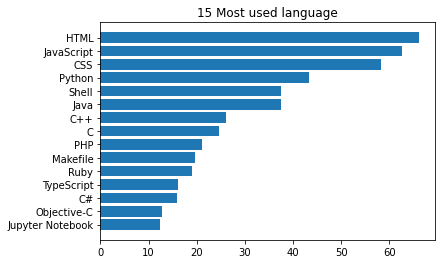

In [9]:
#visualize language percentage
visualize_language_percentage(language_percentage)

In [10]:
print(percentage_use('HTML', lang_data, user_data_dict))
print(percentage_use('Java', lang_data, user_data_dict))

66.16
37.42


#### Languages pairs

In [11]:
#Transform to user-language dataframe (one-hot-encoded)
user_df = to_user_lang_df(user_data_dict)

#15 highest correlated language pairs
lang_pair = get_top_abs_correlations(user_df, 15)
print(lang_pair)

ZAP                       ZIL           0.816489
RUNOFF                    ZIL           0.707100
HLSL                      ShaderLab     0.694613
C                         C++           0.687105
CSS                       JavaScript    0.677127
                          HTML          0.648578
MQL4                      MQL5          0.619651
RUNOFF                    ZAP           0.577339
HTML                      JavaScript    0.567145
Volt                      Zephir        0.539961
C                         Makefile      0.517260
RUNOFF                    eC            0.499985
Inform 7                  ZIL           0.499980
Common Workflow Language  wdl           0.499941
Boogie                    SMT           0.471340
dtype: float64


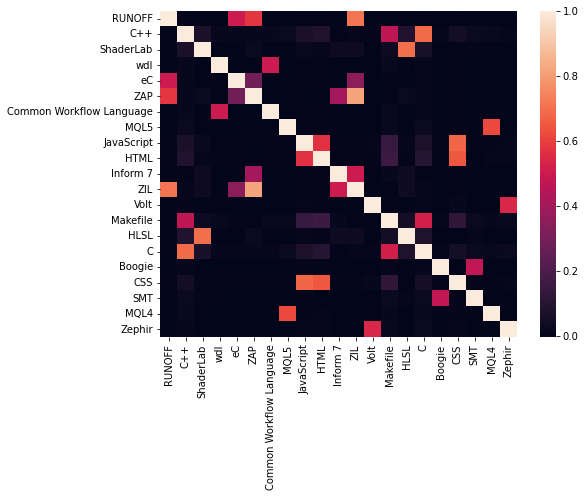

In [12]:
#visualize correlation
visualize_correlated_pair(user_df, lang_pair)

### 3. Grouping GitHub profiles

- Clustering is one way we can do, given the language used. In addition to that we need to have a list of job with their corresponding used language. 
- Or, since we already have the pair correlation, we can derive groups of language that are correlated to each other (Blockmodeling) . And we will still need to additionaly give information about the required programming languages used by each job. Only after that we know which group a profile belongs to.

## Task 2 (Proficiency Measure)

The script can be run through command like by:

```python
python proficiency_measure.py
```

Input :
* User ID (without (''))

Output :
* Languages used by the user
* Calculated user language proficiency

Data preparation :
* Only count repos which are not forked from others (because it might be the case that user forked from others and not change anything about it)
* Filter repos which have no 'name' and 'languages' (because language is what we measure, and name to make it legit serious repo)
* Get only repos which languages' informations are complete, i.e. have name of language and percentage (otherwise we don't know what to count)
* Take max(Forks, stars) as the extra point for users which works are liked by many people / deemed useful by other users. (Validation from others)

Feature Engineering :
* Count language frequencies of the user repos
* Count final point by:
    * Give extra max(Forks, stars)% points for languages that are not too small in percentage (>20%) and liked by 20 to 50 people (stars/forks)
    * Push points to 100% for languages that are used as a major language (>50%) and liked by more than 50 people (crowd's favs!)
    * Pull down the point to 10% if the language frequency is small (<5) and not liked by more than 10 people (to avoid over-appraisal).
    <br> For example: user with only 1 repo which used 100% python would results in average of 100% python proficient.
    * Give extra credits for users who are actively displaying their portfolio <br>
        - Turns to 75% when the final point is less than 75% but have more than 10 repos with corresponding language.
        - Turns to 100% when there are more than 20 repos using corresponding language.
    * Cap the final points by 100%

Calculation : **Average final points grouped by language**

**Further Ideas:**
* Calculate benchmark by relative computing, i.e. superiority compared to other users. 


## Task 3 (GitHub Brainstorming)

Since the main business of Talentwunder is providing profiles which match the job required by users (hiring companies), and also corresponding to the future project Talentwunder is planning (super profile) I will share an idea where the given data can be used for **profile enrichment**.
The idea takes an assumption that we **only** have the provided data.

Given : GitHub profiles <br>
Aim : Profile Enrichment <br>
User : Hiring companies

* Active profiles : We can share the activity level of a profile by its number of contributions. This help users identify profiles which are *progressing*. Of course exact measurement of how we show activity level can be further discussed from many aspects, for examples:
    * Rising star : being active **JUST** recently by posting more original repos, making contributions, liked by others (all by frequency manners compared to other people), can indicate that the profile just entering the Tech world, recently interested in a specific topic, currently building a project. 
    * Git Regulars : regularly active in git. Usually indicate profiles are used to using git, already an established profile. <br>

* Popular profiles : Profiles with outstandingly many forks, stars, watchers.
    * Can also as a stat : "Profile B have a total of X stars, that's higher than 95% of other profiles".
    * Collaborative users : when many people contribute to user repos, indicate the profile can do collaborations, also indicates an interesting repo topic.

* Interest : This is also something which can be useful for recruiters, knowing the interest of each profiles. <br>
If we have **Topic** object, we can already derive the profiles' interests. Alternatively, we can also derive the topics from repos' name, as well as repos' notes (some repos have notes) --> Text Processing. Thus, other than language proficiency, users can also match the interest of the users. 

* Similar profiles: Users are usually also interested to profiles that are comparable in skills for a specific job. Thus giving *similar profiles recommendation* can be helpful for recruiters to approach more people in less time. With our github data, we can calculate similarity by grouping them based on languages they use, more over from their interests that we have derived above.

* Language diversity : A profile which uses many languages can also be attractive to users.